In [1]:
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lit, regexp_replace, lower
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

In [2]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Visualization") \
    .getOrCreate()

In [3]:
data = spark.read.csv('twitter_training.csv', header=False, inferSchema=True)
validation = spark.read.csv('twitter_validation.csv', header=False, inferSchema=True)

# Define column names
columns = ['id', 'Company', 'Label', 'Text']

# Rename columns
for i, col in enumerate(columns):
    data = data.withColumnRenamed('_c{}'.format(i), col)
    validation = validation.withColumnRenamed('_c{}'.format(i), col)

# Drop rows with empty 'Text' column
data = data.dropna(subset=['Text'])
validation = validation.dropna(subset=['Text'])

# Define the StringIndexer for the label column (index the labels)
label_indexer = StringIndexer(inputCol="Label", outputCol="Label2")

# Fit StringIndexer on data
label_indexer_model = label_indexer.fit(data)
data = label_indexer_model.transform(data)
validation = label_indexer_model.transform(validation)

# Extract label mapping
label_mapping = label_indexer_model.labels

def clean_text(df, inputCol="Text", outputCol="cleaned_text"):
    # Remove links starting with https://, http://, www., or containing .com
    df = df.withColumn(outputCol, regexp_replace(df[inputCol], r'https?://\S+|www\.\S+|S+\.com\S+|youtu\.be/\S+', ''))
    # Remove words starting with # or @
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'(@|#)\w+', ''))
    # Convert text to lowercase
    df = df.withColumn(outputCol, lower(df[outputCol]))
    # Remove non-alpha characters
    df = df.withColumn(outputCol, regexp_replace(df[outputCol], r'[^a-zA-Z\s]', ''))
    return df
    
cleaned_data = clean_text(data, inputCol="Text", outputCol="Text")
cleaned_validation = clean_text(validation, inputCol="Text", outputCol="Text")

Phân bố nhãn trong tập train:
        Label  count
0    Negative  22358
1    Positive  20655
2     Neutral  18108
3  Irrelevant  12875

Phân bố nhãn trong tập validation:
        Label  count
0     Neutral    285
1    Positive    277
2    Negative    266
3  Irrelevant    172


C:\Users\DELL\AppData\Local\Temp\ipykernel_18768\359331074.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="count", data=train_counts_pd, ax=axes[0], palette="viridis")
C:\Users\DELL\AppData\Local\Temp\ipykernel_18768\359331074.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Label", y="count", data=val_counts_pd, ax=axes[1], palette="viridis")


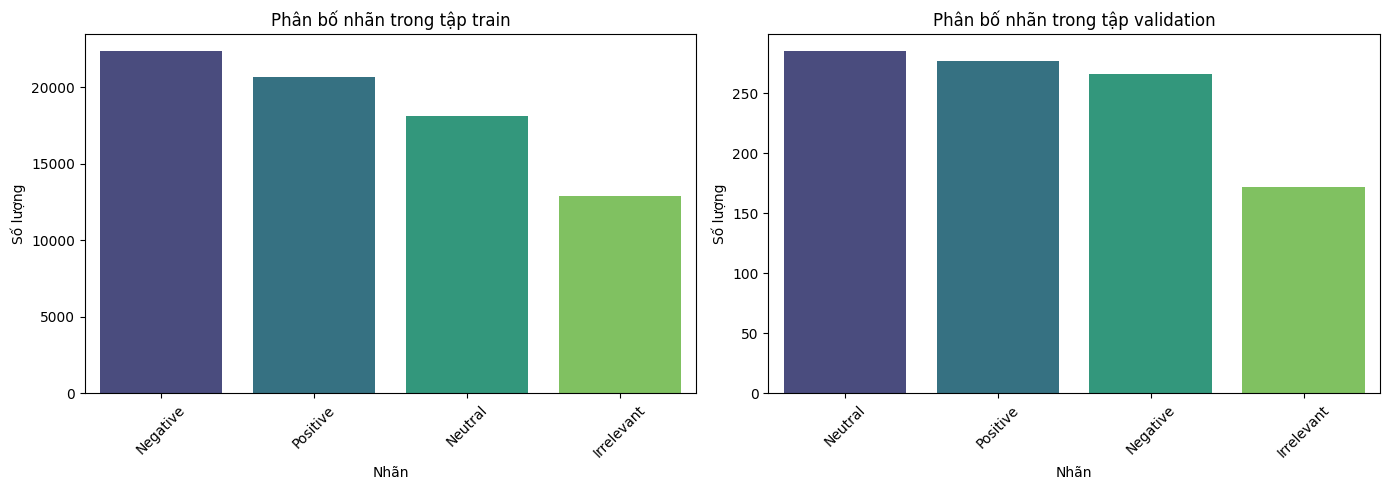

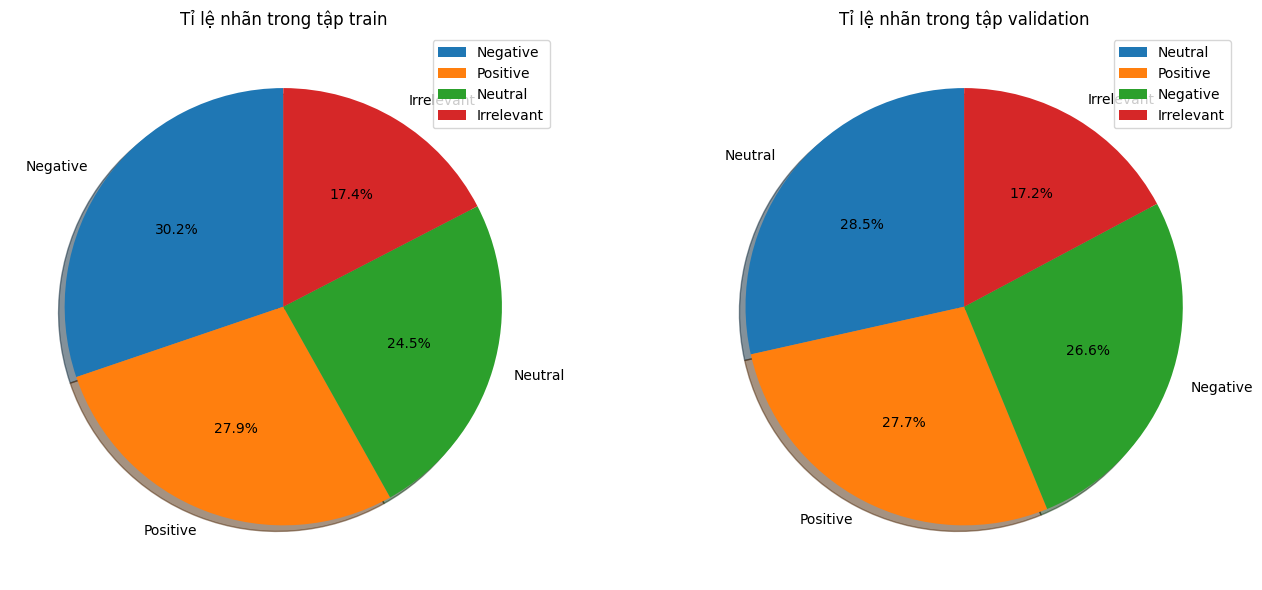

In [4]:
# Đếm nhãn trong tập dữ liệu
label_counts_train = data.groupBy("Label").count().orderBy("count", ascending=False)
label_counts_val = validation.groupBy("Label").count().orderBy("count", ascending=False)

# Chuyển sang pandas để vẽ biểu đồ
train_counts_pd = label_counts_train.toPandas()
val_counts_pd = label_counts_val.toPandas()

# Hiển thị số lượng mỗi nhãn
print("Phân bố nhãn trong tập train:")
print(train_counts_pd)
print("\nPhân bố nhãn trong tập validation:")
print(val_counts_pd)

# Vẽ biểu đồ phân bố nhãn (cả 2 tập dữ liệu)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ cho tập train
sns.barplot(x="Label", y="count", data=train_counts_pd, ax=axes[0], palette="viridis")
axes[0].set_title("Phân bố nhãn trong tập train")
axes[0].set_xlabel("Nhãn")
axes[0].set_ylabel("Số lượng")
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho tập validation
sns.barplot(x="Label", y="count", data=val_counts_pd, ax=axes[1], palette="viridis")
axes[1].set_title("Phân bố nhãn trong tập validation")
axes[1].set_xlabel("Nhãn")
axes[1].set_ylabel("Số lượng")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Thêm biểu đồ hình tròn (pie chart)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart cho tập train
train_counts_pd.plot.pie(y="count", labels=train_counts_pd["Label"], autopct='%1.1f%%', 
                         ax=axes[0], startangle=90, shadow=True)
axes[0].set_title("Tỉ lệ nhãn trong tập train")
axes[0].set_ylabel("")

# Pie chart cho tập validation
val_counts_pd.plot.pie(y="count", labels=val_counts_pd["Label"], autopct='%1.1f%%', 
                       ax=axes[1], startangle=90, shadow=True)
axes[1].set_title("Tỉ lệ nhãn trong tập validation")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [11]:
model_paths = {
    "Logistic Regression": "LR_best_model",
    "Random Forest": "RF_best_model",
    "Naive Bayes": "NB_best_model"
}
results = []

In [12]:
for name, path in model_paths.items():
    model = PipelineModel.load(path)
    predictions = model.transform(cleaned_validation)
    evaluator = MulticlassClassificationEvaluator(labelCol="Label2", predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Đưa kết quả vào DataFrame
df_results = pd.DataFrame(results)
print(df_results)

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression     0.878   0.881513   0.878  0.877403
1        Random Forest     0.457   0.662419   0.457  0.383252
2          Naive Bayes     0.740   0.747648   0.740  0.736290


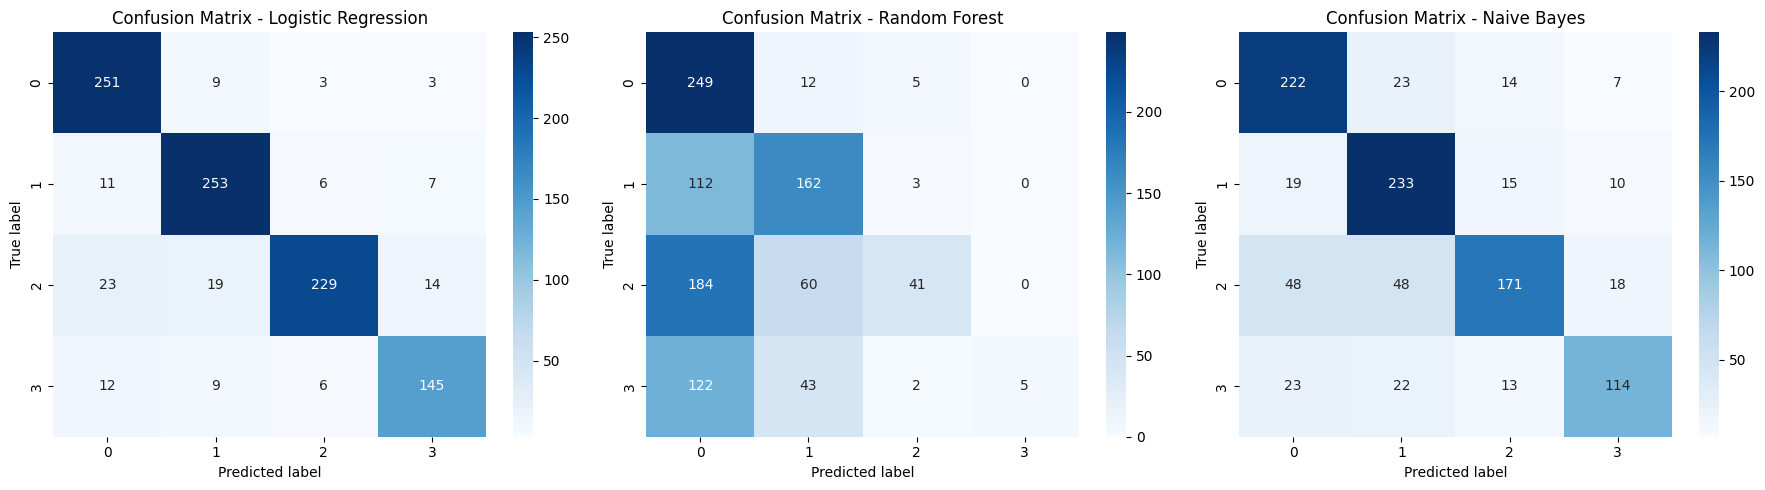

In [13]:
from sklearn.metrics import confusion_matrix

model_names = list(model_paths.keys())
fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))

if len(model_names) == 1:
    axes = [axes]  # Đảm bảo axes là list nếu chỉ có 1 model

for idx, (name, path) in enumerate(model_paths.items()):
    model = PipelineModel.load(path)
    predictions = model.transform(cleaned_validation)
    y_true = predictions.select("Label2").toPandas()
    y_pred = predictions.select("prediction").toPandas()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted label")
    axes[idx].set_ylabel("True label")

plt.tight_layout()
plt.show()

In [14]:
spark.stop()